In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

# Q3: Efficient Tracking

Make sure to comment your code and use proper names for your variables.

## Q3.1: Lucas-Kanade with Inverse Composition

In [32]:
from scipy.interpolate import RectBivariateSpline
# import cv2

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    
    :return[np.array(2, 3)] M   : Affine warp matrix
    """
    # Initial M
    M = np.eye(3)
#     M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your Efficient LK implementation here: 
    p0 = np.zeros(6)
    p = p0
    
    # shift for It and It1 to get It_rec, It1_rec for future .ev()
    h_t,w_t = np.shape(It)
    y_wrap, x_wrap = np.meshgrid(np.linspace(0, h_t, h_t, endpoint = False), np.linspace(0, w_t, w_t, endpoint = False))
    It_rec = RectBivariateSpline(y_wrap[0,:], x_wrap[:, 0], It)
    
    h_1, w_1 = np.shape(It1)
    y1_wrap, x1_wrap = np.meshgrid(np.linspace(0, h_1, h_1, endpoint = False), np.linspace(0, w_1, w_1, endpoint = False))
    It1_rec = RectBivariateSpline(y1_wrap[0,:], x1_wrap[:, 0], It1)
    
    # Get the index of the template pixel
    y, x = np.meshgrid(np.linspace(0, h_t, h_t, endpoint = False),np.linspace(0, w_t, w_t, endpoint = False))
   
    # Create x in homogeneous coordinate: 3x3
    x = np.reshape(x,(1, w_t * h_t))
    y = np.reshape(y,(1, w_t * h_t))
    X_h = np.vstack((x, y, np.ones((1, w_t * h_t))))
    
    # Step-1 Evaluate the gradient of the template T(x)
    gIx = It_rec.ev(y, x, dy=1).flatten()
    gIy = It_rec.ev(y, x, dx=1).flatten() 
    Template = It_rec.ev(y, x).flatten()
    
    # Reshape the matrix to be (N,1):
    x_pos = np.reshape(x, (x.shape[1], 1))
    y_pos = np.reshape(y, (y.shape[1], 1))
    gIx = np.reshape(gIx, (len(gIx), 1))
    gIy = np.reshape(gIy, (len(gIy), 1))
    
    # Step-2 Evaluate Jacobian W at(x;0)
    # Step-3 Compute steepest descent images gI @ J_W
    A1 = np.multiply(gIx, x_pos)
    A2 = np.multiply(gIy, x_pos)
    A3 = np.multiply(gIx, y_pos)
    A4 = np.multiply(gIy, y_pos)

    A_prime = np.hstack((A1,A2,A3,A4,gIx,gIy))
    
    # Compute Hessian matrix (eq36)
    Hei = np.matmul(A_prime.T, A_prime)
    inv_H = np.linalg.pinv(Hei)
   
    for i in range(0, num_iters):
        #x'= Mx
        X_prime = M @ X_h
        
        xp = X_prime[0]
        yp = X_prime[1]
        
        # Step 1- Wrap It1 with W to compute I1(W(x;p))
        It1_wrap = It1_rec.ev(yp, xp).flatten()
       
        # Build linear system A,b:
        # Step 2- Compute error image
        b = (It1_wrap - Template).flatten()
        
        # Step 3- Compute [steepest_decent].T @ b
        tmp = A_prime.T @ b
        
        # Step 4- Compute delta_p using eq 35
        delta_p = inv_H @ tmp

        dp = np.linalg.norm(delta_p)

        # Update the wrap W<-W(x;p) 。 inv(W(x;delta_p))
        delta_M = np.array([[1+delta_p[0], delta_p[2], delta_p[4]],
                            [delta_p[1], 1+delta_p[3], delta_p[5]],
                            [0, 0, 1]])
  
        M = np.matmul(M, np.linalg.pinv(delta_M))

        p = (p+ delta_p.T).ravel()
        if(dp < threshold):
            break

    
    
    # ----------------------------------------------------------------------------------------------
    return M

## Q3.1 Subtract Dominant Motion

Re-use your implementation for Q2.2. 

Just make sure to use InverseCompositionAffine within. 

In [37]:
from scipy.ndimage import binary_erosion, binary_dilation, affine_transform
# import cv2

def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[float] threshold     : For LucasKanadeAffine --> If the length of dp < threshold, 
                                  terminate the optimization
    :param[int] num_iters       : For LucasKanadeAffine --> Number of iterations for running the 
                                  optimization
    :param[float] tolerance     : Binary threshold of intensity difference when computing the mask.
   
    :return[np.array(H, W)] mask: Binary mask indicating moving pixels. 
    """
    mask = np.ones(It1.shape, dtype=bool)

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    M = InverseCompositionAffine(It, It1, threshold, num_iters)
    M_inv = np.linalg.inv(M)
    
    # Wrap the image It using M so that it's registered to It+1
    It_wrap = affine_transform(It, M[0:2,0:2], offset = M[0:2,2], output_shape = It1.shape)
    
    # Substract the wraped image from It+1
    Diff = abs(It1 - It_wrap)
    
    # where absolute diff exceeds a torance can be declared as corresponding to thelocations of moving objects
    mask[Diff <= tolerance] = 0
    
    # Better results for using erosion and dilation
    mask = binary_erosion(mask,structure = np.eye(2))
    mask = binary_dilation(mask,iterations = 2)
    # ----------------------------------------------------------------------------------------------
    return mask 

## Q3.2: Track Sequence

Re-use your implementation for Q2.3

In [38]:
def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] threshold       : If the length of dp < threshold, terminate the optimization
    :param[float] tolerance       : Binary threshold of intensity difference when computing the mask.

    :return[np.array(H, W)] mask: Binary mask indicating moving pixels.
    """
    H, W, N = seq.shape

    masks = []
#     It = seq[:,:,0]

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your code here:
    for i in tqdm(range(N-1)):
        It = seq[:, :, i]
        It1 = seq[:, :, i+1]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)

    # ----------------------------------------------------------------------------------------------
    #masks = np.stack(masks, axis=2)
    return masks

### Q3.2: Track Ant Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [44]:
import time

start_time = time.perf_counter()

seq = np.load("../data/antseq.npy")

# NOTE: feel free to play with these parameters
num_iters = int(1e4)
threshold = 1e-2
tolerance = 0.04

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/antseqmasks.npy', masks)

end_time = time.perf_counter()

processing_time = end_time - start_time
print(f"Processing time: {processing_time} seconds")

100%|█████████████████████████████████████████| 124/124 [00:15<00:00,  8.18it/s]

Processing time: 15.189663667000332 seconds


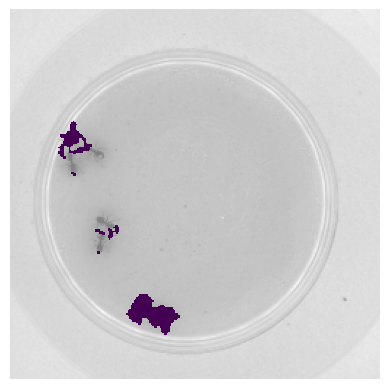

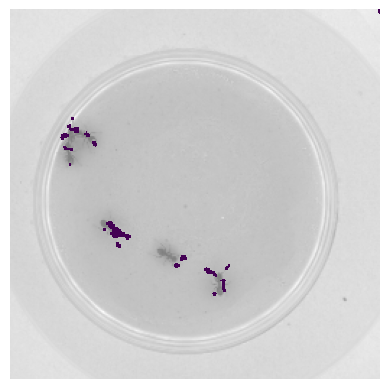

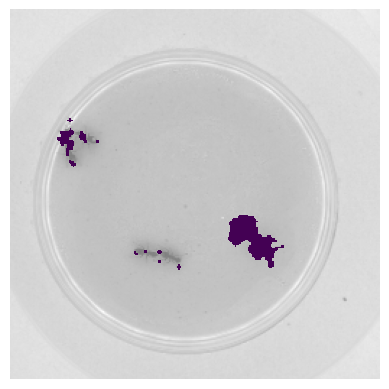

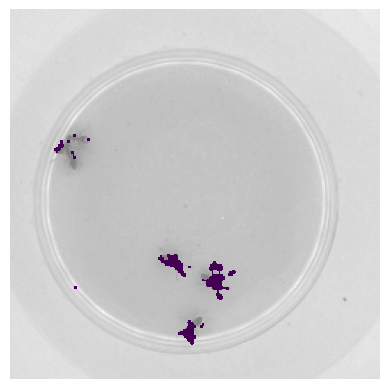

In [41]:
# TODO: visualize. Re-use your implementation for Q2.3
frames_to_save = [30, 60, 90, 120]

for idx in frames_to_save:
    frame = seq[:,:,idx]
    mask = masks[idx-1]
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_3.2_antseq_{idx}.png")

### Q3.2: Test Aerial Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [45]:
import time

start_time = time.perf_counter()

seq = np.load("../data/aerialseq.npy")

# NOTE: feel free to play with these parameters
num_iters = int(1e4)
threshold = 1e-2
tolerance = 0.18

masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
np.save(f'../out/aerialseqmasks.npy', masks)

end_time = time.perf_counter()

processing_time = end_time - start_time
print(f"Processing time: {processing_time} seconds")

100%|█████████████████████████████████████████| 149/149 [00:43<00:00,  3.41it/s]

Processing time: 43.69659066699978 seconds


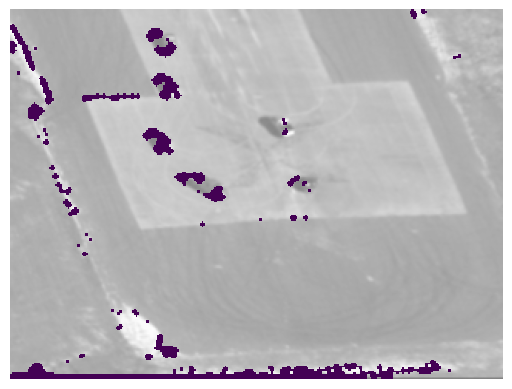

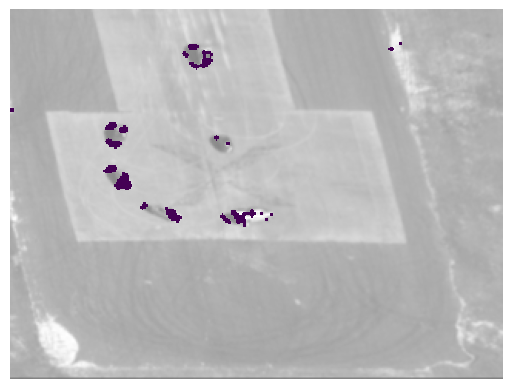

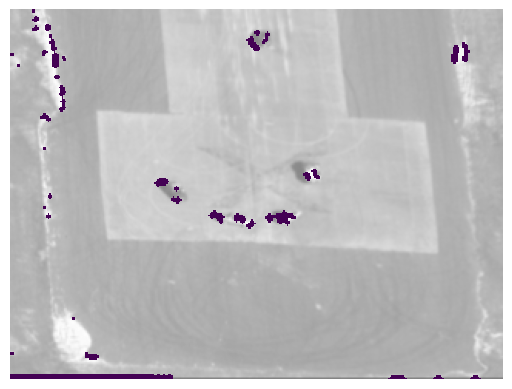

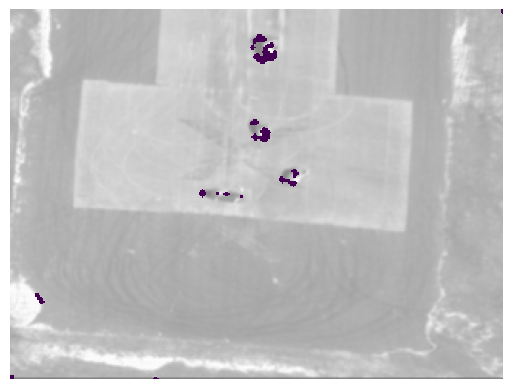

In [43]:
# TODO: visualize. Re-use your implementation for Q2.3
frames_to_save = [30, 60, 90, 120]

for idx in frames_to_save:
    frame = seq[:,:, idx]
    mask = masks[idx-1]
    
    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask))
    plt.axis('off')
    plt.savefig(f"../out/sol_3.2_aerialseq_{idx}.png")